In [1]:
from music21 import *
import os
import xml.etree.ElementTree as ET
import pandas as pd
from rich import print
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
mscore_path = '/usr/bin/mscore'
us = environment.UserSettings()
us['musicxmlPath'] = mscore_path
us['musescoreDirectPNGPath'] = mscore_path

In [3]:
# mscore_path = '/Applications/MuseScore 4.app/Contents/MacOS/mscore'
# us = environment.UserSettings()
# us['musicxmlPath'] = mscore_path
# us['musescoreDirectPNGPath'] = mscore_path

In [4]:
data_path = './SymbTr'
music_xml_path = os.path.join(data_path, 'MusicXML')
music_xml_nokeysig_path = os.path.join(data_path, 'MusicXML_NoKeySig')

In [5]:
s = converter.parse(music_xml_path + '/acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml')
# s.show()

In [6]:
all_scores = os.listdir(music_xml_path)
label_map = {}
for score in all_scores:
    label = score.split('--')[2]
    if label not in label_map:
        label_map[label] = []
    label_map[label].append(score)

In [7]:
sorted_items = sorted(label_map.items(), key=lambda x: len(x[1]), reverse=True)
# print(list(zip(label_map.keys(), [len(value) for value in label_map.values()])))

In [8]:
if not os.path.exists(music_xml_nokeysig_path):
    beatsDic = {}

    # Create a folder to contain the xml scores without key signature
    os.mkdir(music_xml_nokeysig_path)

    for score in all_scores:
        # print(all_scores.index(score)+1, '- Processing', score)
        
        # Remove the key signature from the xml file
        tree = ET.parse(os.path.join(music_xml_path, score))
        root = tree.getroot()
        
        for att in root.iter('attributes'):
            if att.find('key'):
                att.remove(att.find('key'))
        
        # Save the new xml files to be later loaded with music21
        new_score = os.path.join(music_xml_nokeysig_path, score)
        tree.write(new_score)
        
        # Load the file in music21 and get a stream with all the notes
        s = converter.parse(new_score)
        nn = s.flatten().notes.stream()
        
        # Count the notes per beat
        for n in nn:
            beatsDic[n.beat] = beatsDic.get(n.beat, 0) + 1 # Use the .beat attibute

    print('\nDone!')
else:
    print(f'The folder {music_xml_nokeysig_path} already exists. Skipping the process.')

The folder ./SymbTr/MusicXML_NoKeySig already exists. Skipping the process.

In [9]:
all_new_scores = os.listdir(music_xml_nokeysig_path)
new_label_map = {}
for score in all_new_scores:
    label = score.split('--')[2]
    if label not in new_label_map:
        new_label_map[label] = []
    new_label_map[label].append(score)

In [10]:
# new_sorted_items = sorted(new_label_map.items(), key=lambda x: len(x[1]), reverse=True)
# for key, value in new_sorted_items:
#   time_sigs = set()
#   for score in value:
#     s = converter.parse(music_xml_nokeysig_path + '/' + score)
#     time_signature = s.getTimeSignatures()[0].ratioString
#     time_sigs.add(time_signature)
#   print(key, len(value), time_sigs)

## Build data frame

In [11]:
blacklist = [
    'beyati--sarki--duyek--ruhuma_sundugun--sadettin_kaynak.xml',
    'saba--miraciye--serbest--pes_heman--nayi_osman_dede.xml',
]

df_columns = [
    'path',
    'makam_file',
    'form_file',
    'usul_file',
    'lyrics_file',
    'composer_file',
    'composer',
    'poet',
    'work_title',
    'bar_count',
    'music',
]
df = pd.DataFrame(columns=df_columns)

all_scores = os.listdir(music_xml_nokeysig_path)
for score in all_scores:
    if score in blacklist: continue
    
    R_path = os.path.join(music_xml_nokeysig_path, score)

    # Data in the filename
    filename_data = score.split(".xml")[0].split("--")
    R_makam_file = filename_data[0]
    R_form_file = filename_data[1]
    R_usul_file = filename_data[2]
    R_lyrics_file = filename_data[3]
    R_composer_file = filename_data[4]

    # Load the file in music21
    s = converter.parse(R_path)

    # Metadata data
    m = s.metadata
    p = s.parts[0]
    measures = p.getElementsByClass(stream.Measure)
    R_composer = m.getContributorsByRole("composer")[0].name
    R_poet = m.getContributorsByRole("poet")[0].name if m.getContributorsByRole("poet") else None
    R_work_title = m.title
    R_bar_count = len(measures)
    R_music = []

    last_makam = None
    last_form = None
    last_usul = None
    last_tempo = None


    try:
        for m in measures:
            text_expressions = m.getElementsByClass('TextExpression')
            if text_expressions:
                te = text_expressions[0]
                keys = []
                values = []
                for item in te.content.split(','):
                    key, value = item.split(': ')
                    keys.append(key)
                    values.append(value)
                expr = {k.strip(): v.strip() for k, v in zip(keys, values)}
                if expr.get('Makam'): last_makam = expr['Makam']
                if expr.get('Form'): last_form = expr['Form']
                if expr.get('Usul'): last_usul = expr['Usul']

            tempo = m.getElementsByClass('MetronomeMark')
            if tempo:
                t = tempo[0]
                last_tempo = t.number

            time_signature = m.getTimeSignatures()[0]
            R_mi = {
                "time_signature": time_signature.ratioString,
                "makam": last_makam,
                "tempo": last_tempo,
                "usul": last_usul,
                "form": last_form,
                "notes": [],
                "beat_data": [0] * time_signature.numerator,
            }
            beat_n = 0
            duration_sum = 0

            for n in m.notes:
                if n.duration.isGrace: continue
                if n.isNote:
                    R_mi["beat_data"][beat_n] += 1
                duration = n.duration.quarterLength
                duration_sum += duration
                beat_n = math.floor(duration_sum * 96 / (384 / time_signature.denominator)) # TODO: do not hardcode

                R_mi["notes"].append({
                    "step": n.step,
                    "octave": n.octave,
                    # "lyric": n.lyric if n.lyric else None,
                    "duration": duration,
                })
            
            R_music.append(R_mi)
    except Exception as e:
        print(f'Error processing {R_path}: {e}')
        continue

    # Create a dictionary with the results
    new_row = {
        'path': R_path,
        'makam_file': R_makam_file,
        'form_file': R_form_file,
        'usul_file': R_usul_file,
        'lyrics_file': R_lyrics_file,
        'composer_file': R_composer_file,
        'composer': R_composer,
        'poet': R_poet,
        'work_title': R_work_title,
        'bar_count': R_bar_count,
        'music': R_music,
    }

    # Append the new row to the dataframe
    df = pd.concat([df, pd.DataFrame([new_row], columns=df_columns)], ignore_index=True)

In [12]:
df.head()

,path,makam_file,form_file,usul_file,lyrics_file,composer_file,composer,poet,work_title,bar_count,music
0,./SymbTr/MusicXML_NoKeySig/hicaz--sarki--nimso...,hicaz,sarki,nimsofyan,yar_saclari,yesari_asim_arsoy,Yesârî Âsım Arsoy,Yesârî Âsım Arsoy,Yâr Saçları Lüle Lüle,145,"[{'time_signature': '2/4', 'makam': 'Hicaz', '..."
1,./SymbTr/MusicXML_NoKeySig/muhayyerkurdi--sark...,muhayyerkurdi,sarki,curcuna,bakisi_cagirir,selahaddin_pinar,Selahaddin Pınar,Fuad Edip Baksı,Bakışı Çağırır Beni Uzaktan,82,"[{'time_signature': '10/8', 'makam': 'Muhayyer..."
2,./SymbTr/MusicXML_NoKeySig/nihavent--sarki--ag...,nihavent,sarki,agiraksak,akibet_viran,numan_aga,Numan Ağa,?,Akıbet Viran,32,"[{'time_signature': '9/4', 'makam': 'Nihâvent'..."
3,./SymbTr/MusicXML_NoKeySig/hicaz--beste--agird...,hicaz,beste,agirduyek,ey_cesm-i,dede_efendi,Dede Efendi,Kadı Mehmet Riyâzî,Ey Çeşm-I Âhû,53,"[{'time_signature': '8/4', 'makam': 'Hicaz', '..."
4,./SymbTr/MusicXML_NoKeySig/ussak--sarki--curcu...,ussak,sarki,curcuna,hastasin_zannim,sevki_bey,Şevki Bey,Mehmed Hafîd Bey,Hastasın Zannım Vefâ Mahzunusun,56,"[{'time_signature': '10/8', 'makam': 'Uşşak', ..."


## Compute beat data overview

In [19]:
VALID_USULS_FILENAME = ['sofyan']
VALID_USULS_SHEET = [
    "Sofyan (4/8)",
    "Sofyan",
]

def usul_sheet_to_filename(usul):
    if not usul in VALID_USULS_SHEET: return None
    usul_sheet = usul.split(' ')[0]
    if usul_sheet in ["Sofyan (4/8)", "Sofyan"]: return 'sofyan'
    elif usul_sheet in ["Türkaksağı (5/4)", "Türkaksağı"]: return 'turkaksagi'
    elif usul_sheet in ["Türkaksağı (5/4)", "Türkaksağı"]: return 'turkaksagi'
    elif usul_sheet in ["Aksak (9/4)", "Aksak"]: return 'aksak'
    elif usul_sheet in ["Semâî (3/8)", "Semâî"]: return 'semai'
    elif usul_sheet in ["Düyek (8/4)", "Düyek"]: return 'duyek'
    elif usul_sheet in ["Curcuna"]: return 'curcuna'
    return None

# ---

beat_data_overview = []
for i, row in df.iterrows():
    music = row['music']

    beat_data_summary = {}
    for m in music:
        usul = m['usul']
        if usul not in VALID_USULS_SHEET: continue
        usul = usul_sheet_to_filename(usul)
        if usul != row['usul_file']: continue
        
        if usul not in beat_data_summary:
            beat_data_summary[usul] = {
                'full_beat_data': m['beat_data'],
                'measure_count': 1,
                'mean_diff': None,
            }
        else:
            beat_data_summary[usul]['full_beat_data'] = list(np.add(beat_data_summary[usul]['full_beat_data'], m['beat_data']))
            beat_data_summary[usul]['measure_count'] += 1
    
    for usul, beat_data_sum in beat_data_summary.items():
        beat_data_summary[usul]['mean_diff'] = list(np.array(beat_data_sum['full_beat_data']) / beat_data_sum['measure_count'])
        beat_data_summary[usul]['norm_mean_diff'] = list(np.array(beat_data_sum['mean_diff']) / max(beat_data_sum['mean_diff']))
    
    beat_data_overview.append({
        'id': i,
        'path': row['path'],
        'summary': beat_data_summary,
    })

In [24]:
item = beat_data_overview[0]
for usul, beat_data_sum in item['summary'].items():
    print(usul)
    print(beat_data_sum['full_beat_data'])
    print(beat_data_sum['mean_diff'])
    print(beat_data_sum['norm_mean_diff'])

    mean_diff = beat_data_sum['mean_diff']
    n = len(mean_diff)

    plt.figure()
    sns.barplot(x=np.arange(n), y=mean_diff)
    plt.show()

In [25]:
usul_beat_overview = {}
for item in beat_data_overview:
    for usul, beat_data_sum in item['summary'].items():
        if usul not in usul_beat_overview:
            usul_beat_overview[usul] = {
                'norm_sum': beat_data_sum['norm_mean_diff'],
                'count': 1,
            }
        else:
            usul_beat_overview[usul]['norm_sum'] = list(np.add(usul_beat_overview[usul]['norm_sum'], beat_data_sum['norm_mean_diff']))
            usul_beat_overview[usul]['count'] += 1

for usul, beat_overview in usul_beat_overview.items():
    usul_beat_overview[usul]['norm_mean'] = list(np.array(beat_overview['norm_sum']) / beat_overview['count'])
    usul_beat_overview[usul]['norm_mean'] = list(np.array(usul_beat_overview[usul]['norm_mean']) / max(usul_beat_overview[usul]['norm_mean']))

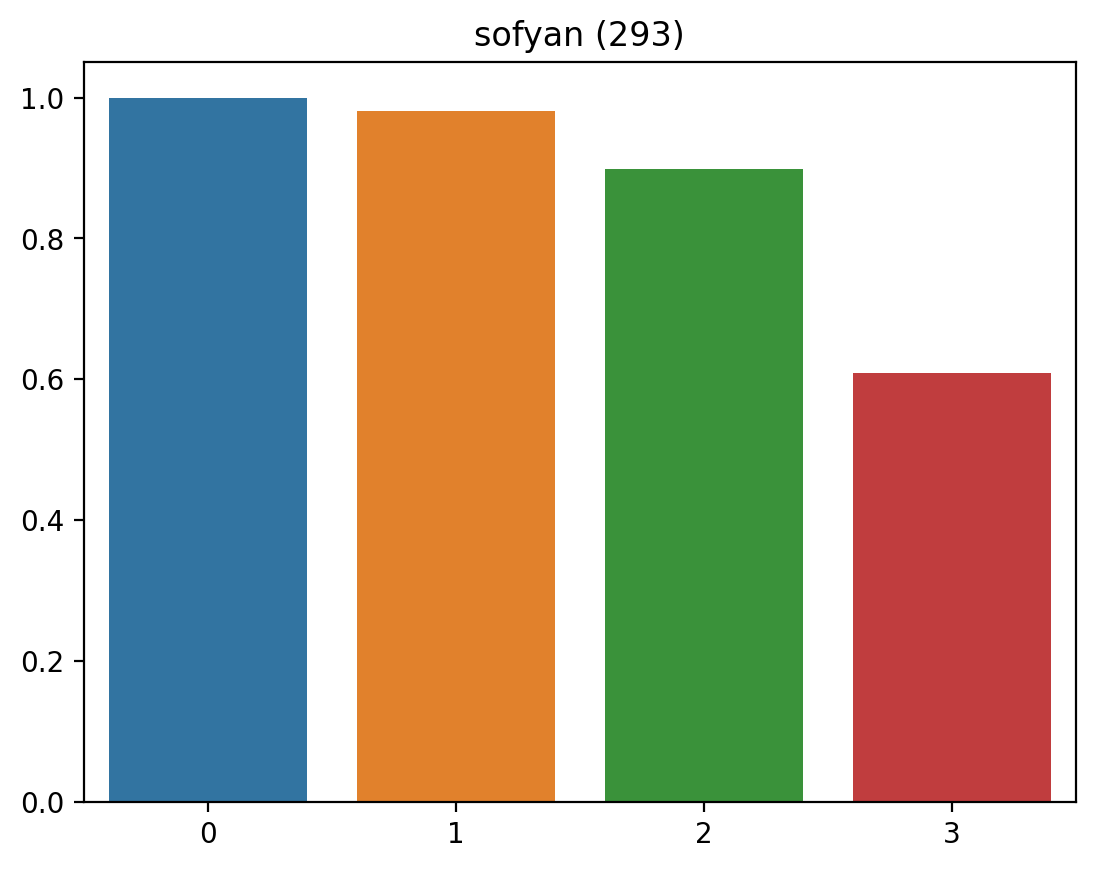

In [26]:
for usul, beat_overview in usul_beat_overview.items():
    beat_count = beat_overview['count']
    # print(usul, beat_overview['count'])
    # print(beat_overview['norm_mean'])

    mean_diff = beat_overview['norm_mean']
    n = len(mean_diff)

    plt.figure()
    sns.barplot(x=np.arange(n), y=mean_diff)
    plt.title(f'{usul} ({beat_count})')
    plt.show()

## Beat data difference between two consecutive beats

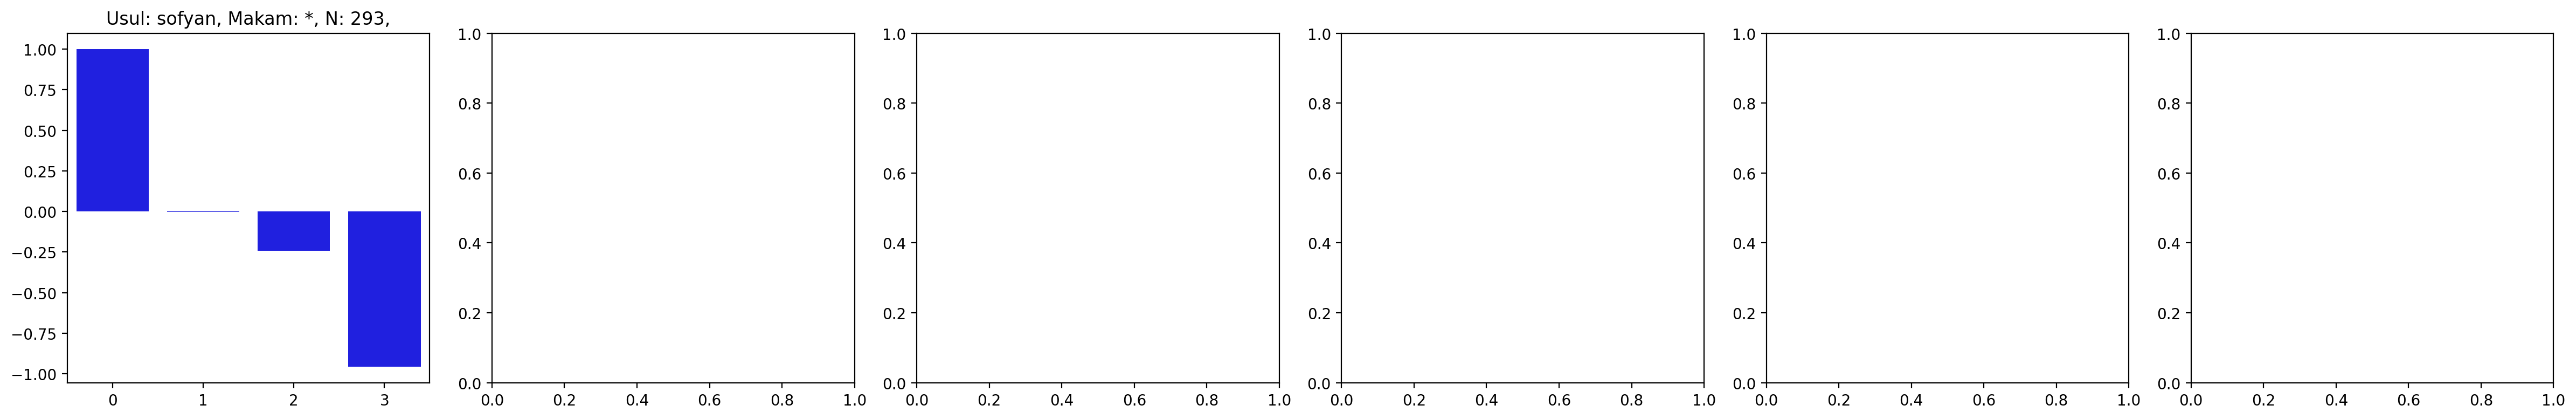

In [27]:
def splice_list(lst, size):
    return [lst[i:i + size] for i in range(0, len(lst), size)]

def sum_lists(list_of_lists):
    return [sum(sublist) for sublist in zip(*list_of_lists)]

# ---

def plot_beat_diff(data, color='blue', makam=None):
    beat_data_diff_overview = {}
    for i, row in data.iterrows():
        music = row['music']

        full_beat_datas = []
        measure_length = None
        usul_file = row['usul_file']
        if usul_file not in VALID_USULS_FILENAME: continue

        for m in music:
            usul = m['usul']
            if usul not in VALID_USULS_SHEET: continue
            usul = usul_sheet_to_filename(usul)
            if usul != row['usul_file']: continue

            full_beat_datas += m['beat_data']
            if measure_length == None:
                measure_length = len(m['beat_data'])

        if usul_file not in beat_data_diff_overview:
            beat_data_diff_overview[usul_file] = {
                'full_beat_data': [full_beat_datas],
                'measure_length': measure_length,
            }
        else:
            beat_data_diff_overview[usul_file]['full_beat_data'].append(full_beat_datas)

    for usul, beat_data_diff in beat_data_diff_overview.items():
        measure_length = beat_data_diff['measure_length']
        full_beat_data_diff = []
        full_beat_data_diff_seg = []
        full_beat_data_diff_seg_sum = []
        full_beat_data_diff_seg_sum_norm = []

        for full_beat_data in beat_data_diff['full_beat_data']:
            
            distance_list = [0] + list(np.abs((np.diff(full_beat_data))))
            full_beat_data_diff.append(distance_list)

            seg_list = splice_list(distance_list, measure_length)
            full_beat_data_diff_seg.append(seg_list)

            seg_sum = sum_lists(seg_list)
            full_beat_data_diff_seg_sum.append(seg_sum)

            seg_sum_norm = list(np.array(seg_sum) / max(seg_sum))
            full_beat_data_diff_seg_sum_norm.append(seg_sum_norm)
        
        sum_norms = sum_lists(full_beat_data_diff_seg_sum_norm)
        beat_data_diff_overview[usul]['diff_norm'] = list(np.array(sum_norms) / max(sum_norms))

    # for usul, beat_data_diff in beat_data_diff_overview.items():
    #     beat_count = len(beat_data_diff['full_beat_data'])

    #     mean_diff = beat_data_diff['diff_norm']
    #     n = len(mean_diff)

    #     plt.figure()
    #     sns.barplot(x=np.arange(n), y=mean_diff)
    #     plt.title(f'{usul} ({beat_count})')
    #     plt.show()

    for usul, beat_data_diff in beat_data_diff_overview.items():
        measure_length = beat_data_diff['measure_length']
        full_beat_data_diff = []
        full_beat_data_diff_seg = []
        full_beat_data_diff_seg_sum = []
        full_beat_data_diff_seg_sum_norm = []

        for full_beat_data in beat_data_diff['full_beat_data']:
            
            difference_list = [0] + list((np.diff(full_beat_data)))
            full_beat_data_diff.append(difference_list)

            dseg_list = splice_list(difference_list, measure_length)
            full_beat_data_diff_seg.append(dseg_list)

            dseg_sum = sum_lists(dseg_list)
            full_beat_data_diff_seg_sum.append(dseg_sum)

            if max(dseg_sum) != 0: seg_sum_norm = list(np.array(dseg_sum) / max(dseg_sum))
            else: seg_sum_norm = dseg_sum
            full_beat_data_diff_seg_sum_norm.append(seg_sum_norm)
        
        sum_norms = sum_lists(full_beat_data_diff_seg_sum_norm)
        beat_data_diff_overview[usul]['diff_norm'] = list(np.array(sum_norms) / max(sum_norms))

    fig, axs = plt.subplots(1, 6, figsize=(24, 4))  # 6 rows, 1 column for 6 subplots

    beat_data_diff_overview = dict(sorted(beat_data_diff_overview.items(), key=lambda x: x[0]))
    for i, (usul, beat_data_diff) in enumerate(beat_data_diff_overview.items()):
        beat_count = len(beat_data_diff['full_beat_data'])
        mean_diff = beat_data_diff['diff_norm']
        n = len(mean_diff)
        
        # Plot using Seaborn barplot.
        # plot a color palette based on the y-axis value
        sns.barplot(x=np.arange(n), y=mean_diff, ax=axs[i], color=color)
        axs[i].set_title(f'Usul: {usul}, Makam: {makam if makam else "*"}, N: {beat_count},')

    plt.tight_layout()
    plt.show()

plot_beat_diff(df)

## Filter by Makam

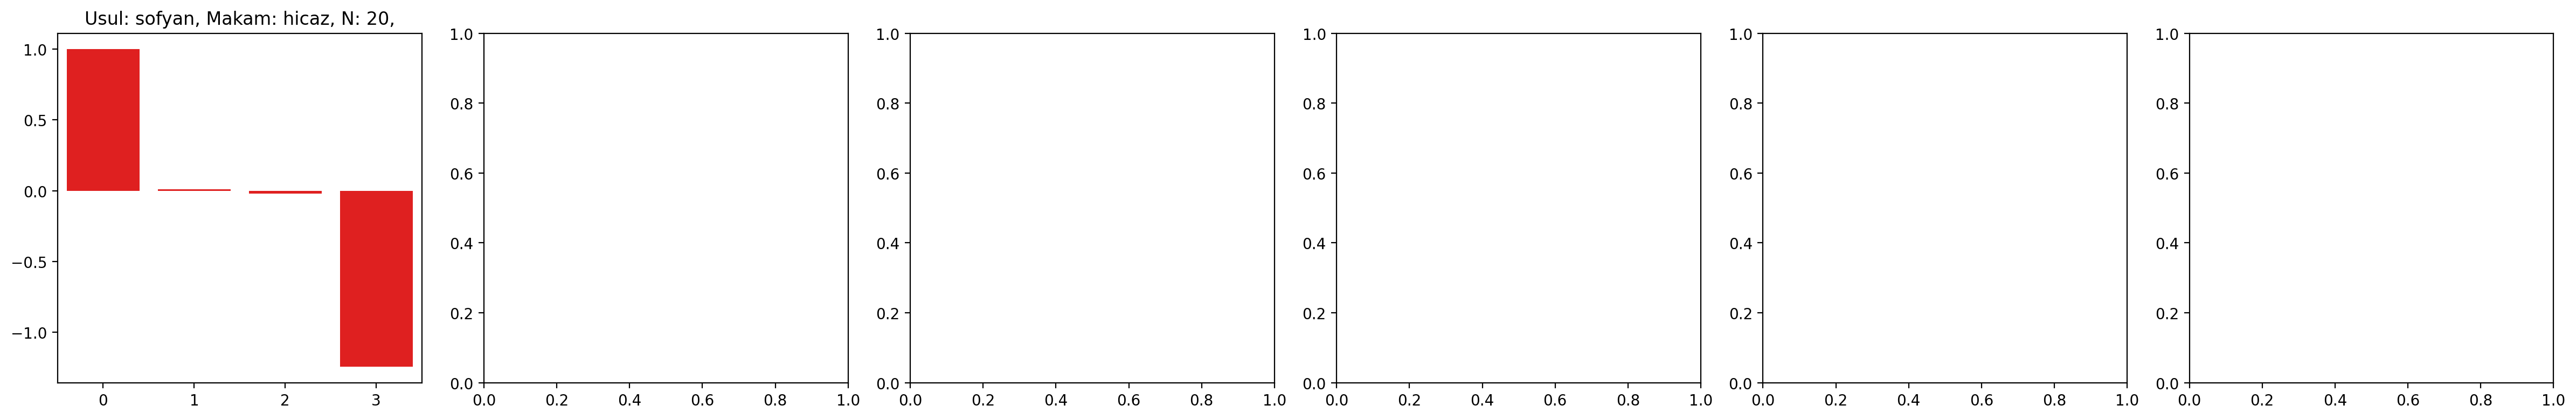

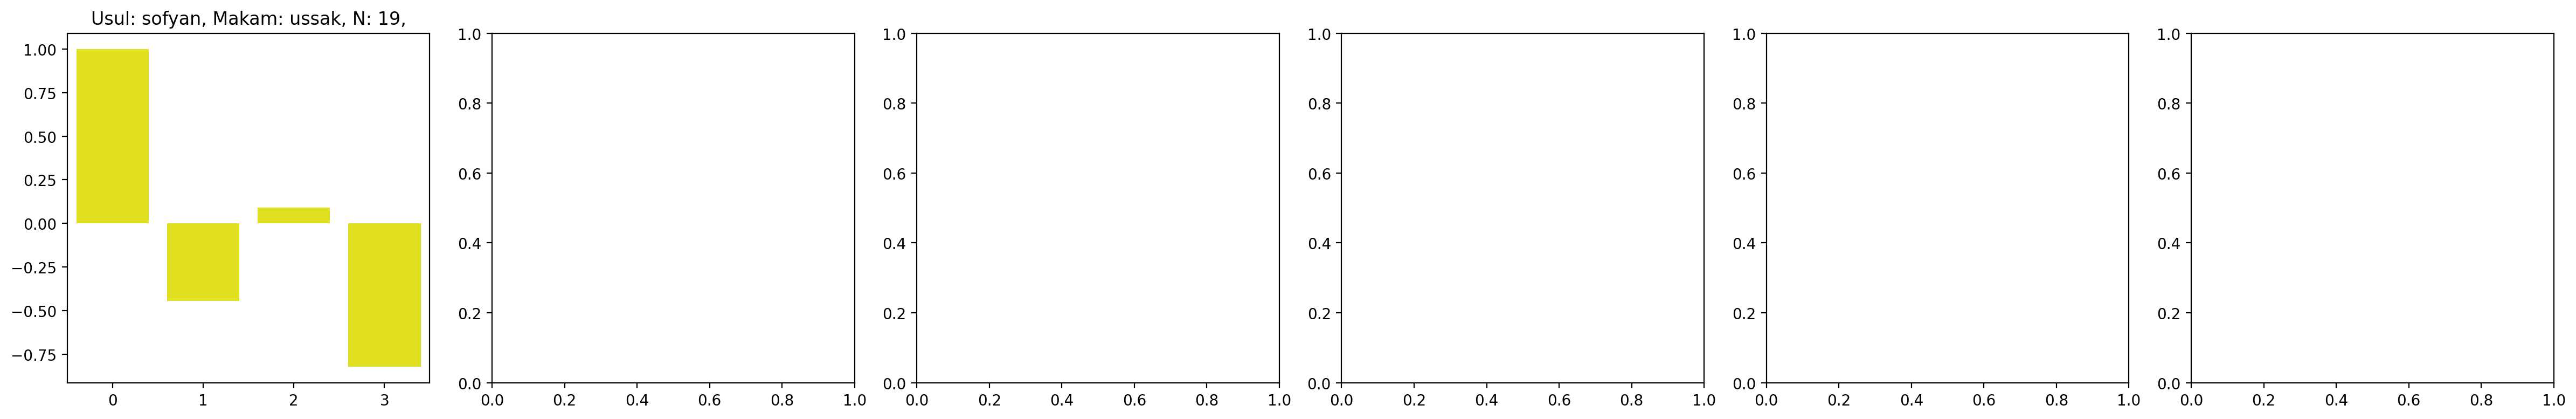

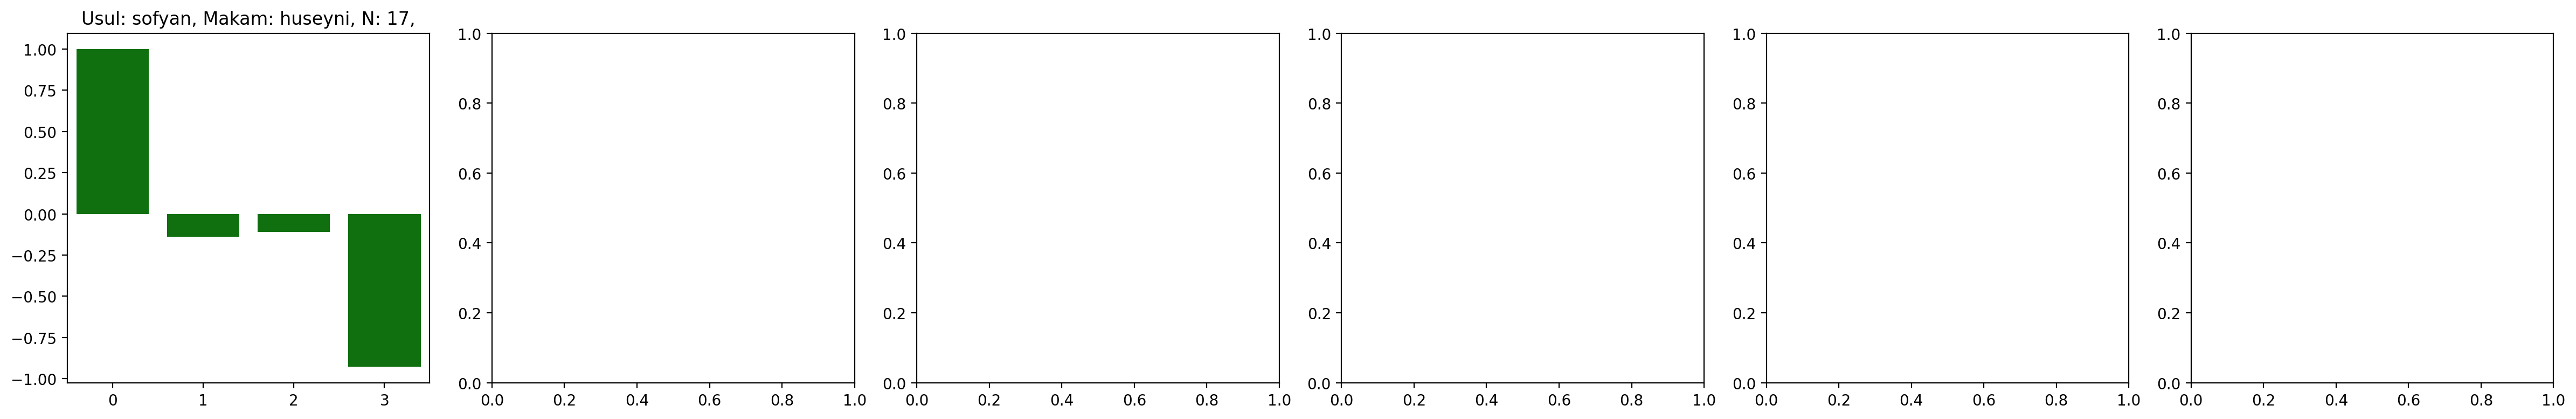

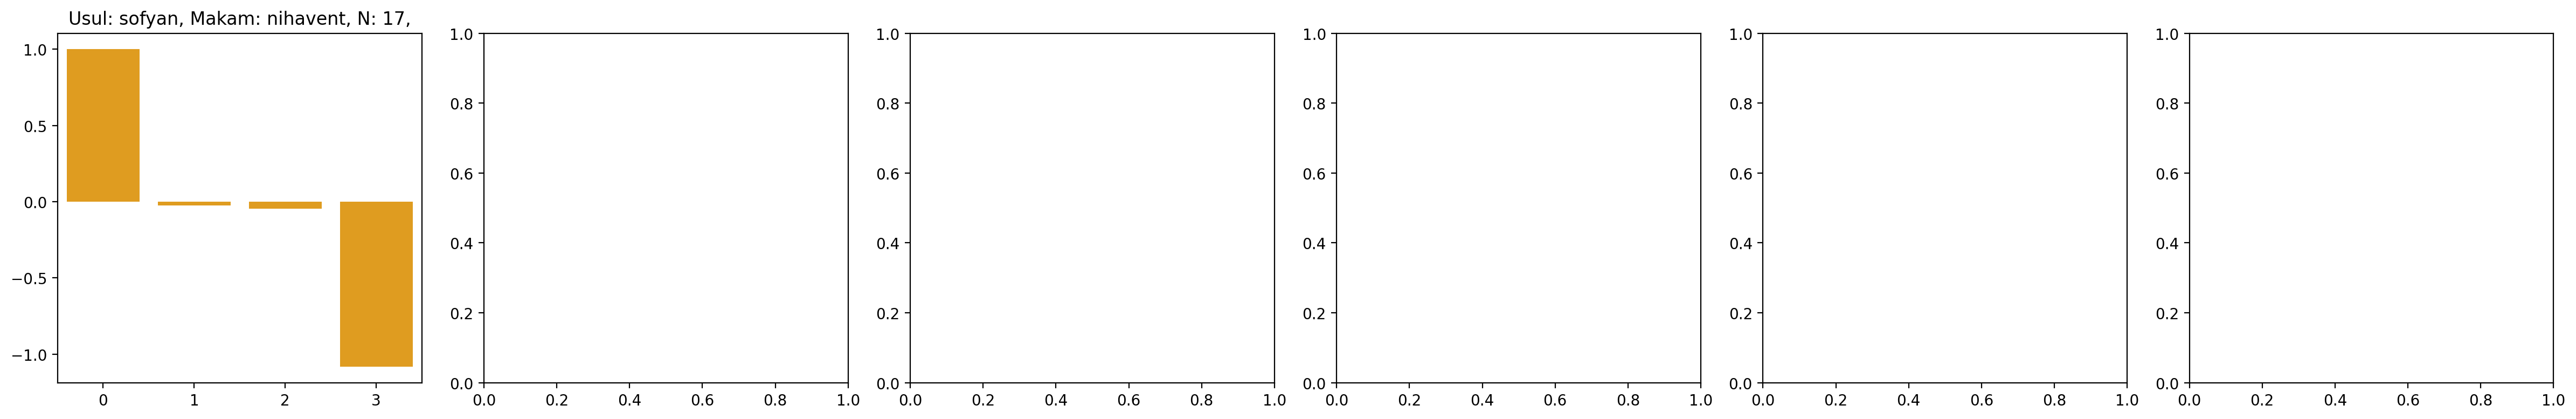

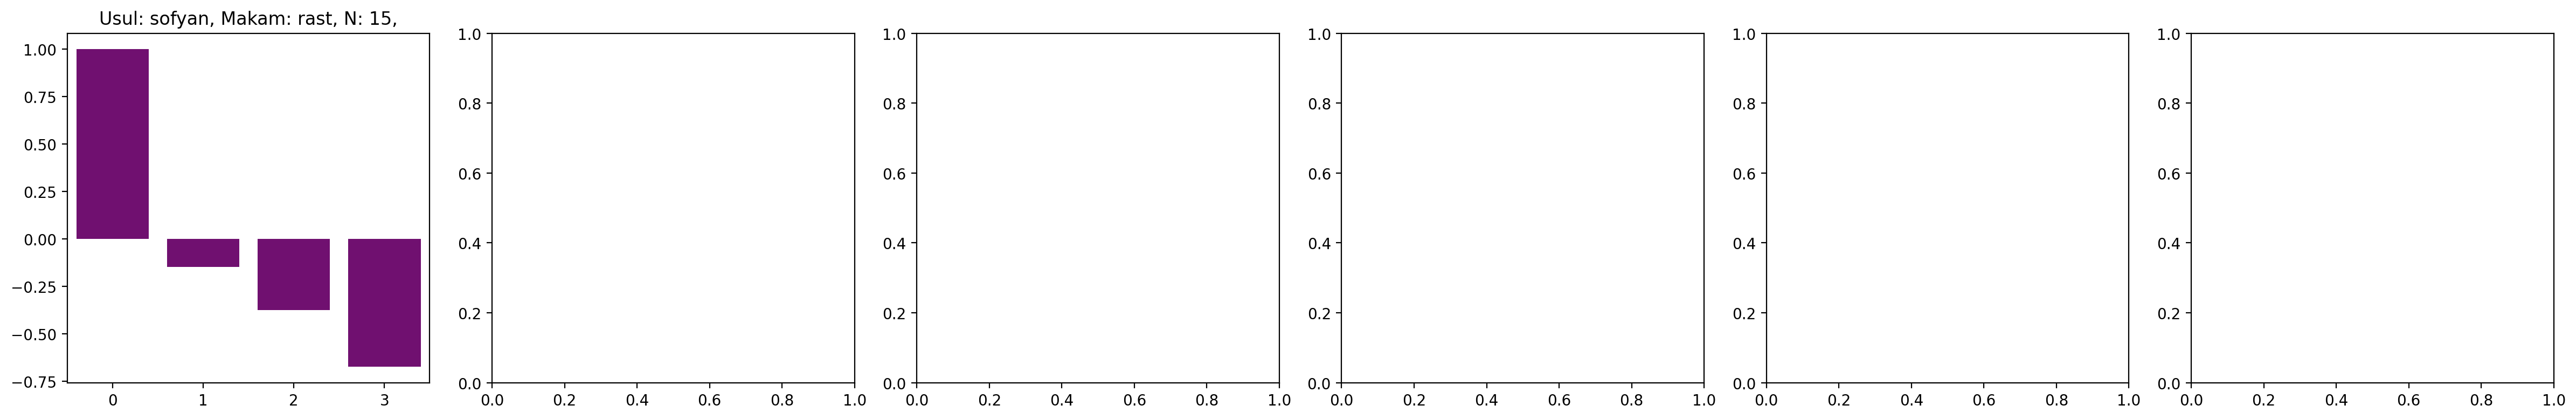

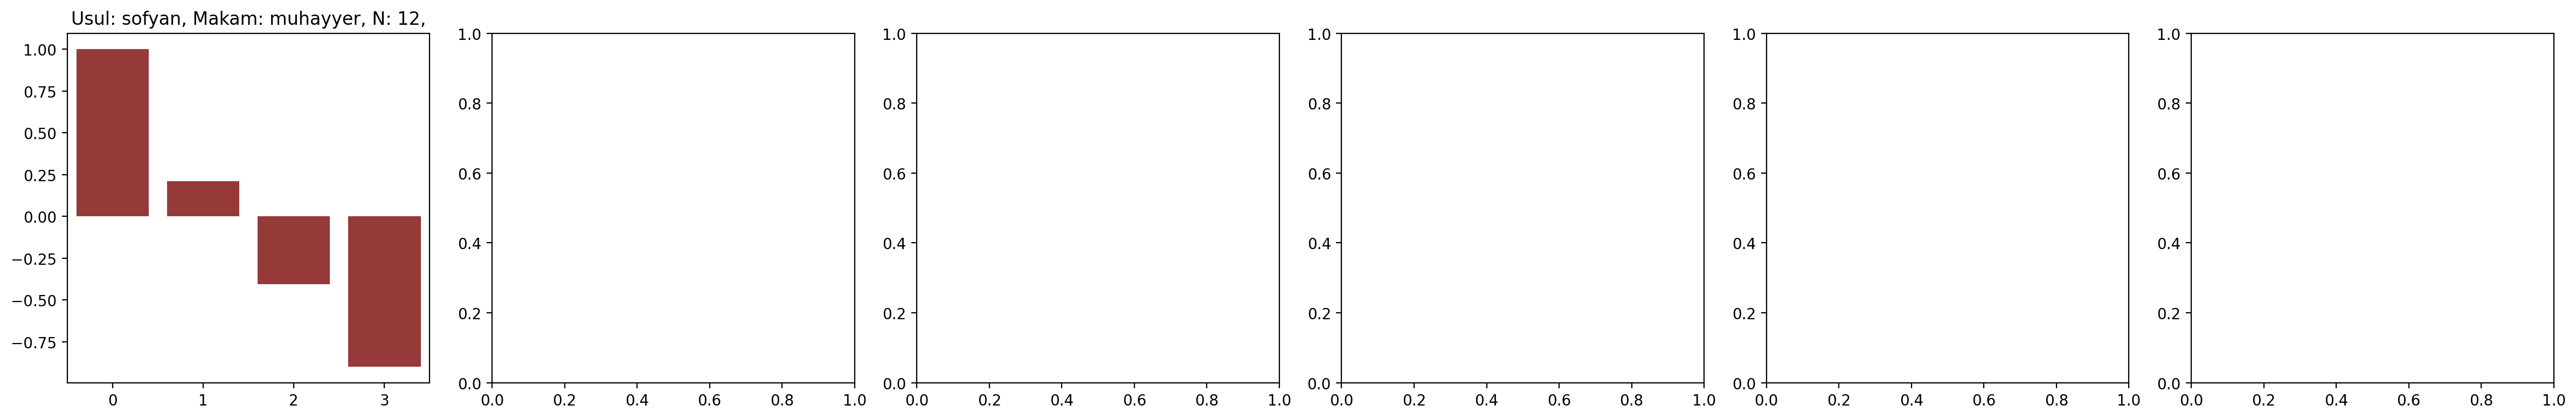

In [28]:
filtered_df = df[df['usul_file'].isin(VALID_USULS_FILENAME)]
colors = ['red', 'yellow', 'green', 'orange', 'purple', 'brown']

# Define the list
my_list = list(filtered_df['makam_file'])

# Count the occurrences
occurrences = Counter(my_list)

sorted_occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)

for i, (makam, count) in enumerate(sorted_occurrences[:6]):
    df_makam = df[df['makam_file'] == makam]
    plot_beat_diff(df_makam, colors[i], makam)

In [33]:
filtered_df = df[df['usul_file'].isin(['sofyan'])]
colors = ['red', 'yellow', 'green', 'orange', 'purple', 'brown']

# Define the list
my_list = list(filtered_df['form'])

# Count the occurrences
occurrences = Counter(my_list)

sorted_occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)

for i, (makam, count) in enumerate(sorted_occurrences[:6]):
    df_makam = df[df['makam_file'] == makam]
    plot_beat_diff(df_makam, colors[i], makam)

KeyError: 'form'